In [1]:
%pylab inline
%matplotlib inline
pylab.rcParams['figure.figsize'] = (16, 9)
%load_ext autoreload
%autoreload 2

# numpy, matplotib and others
import numpy as np
from numpy.random import RandomState
from numpy.linalg import cholesky
import matplotlib.pyplot as plt
import os
import pickle

# L63 and L96 models using fortran (fast)
import models.l63f as mdl_l63
import models.l96f as mdl_l96

# L63 and L96 models using python (slow)
from models.L63 import l63_predict, l63_jac
from models.L96 import l96_predict, l96_f

# data assimilation routines
from algos.EM_ETKS import ETKS, EM_ETKS
from algos.EM_EnKS import EnKS, EM_EnKS
from algos.EM_EKS import EKS, EM_EKS
from algos.utils import climat_background, RMSE, gen_truth, gen_obs

Populating the interactive namespace from numpy and matplotlib


In [2]:
### GENERATE SIMULATED DATA (LORENZ-63 MODEL)

# random number generator
prng = RandomState(9)

# dynamical model
Nx = 3 # dimension of the state
dt = .01 # integration time
sigma = 10;rho = 28;beta = 8./3 # physical parameters
#f = lambda x: l63_predict(x, dt, sigma, rho, beta) # python version (slow)
fmdl=mdl_l63.M(sigma=sigma, rho=rho, beta=beta, dtcy=dt)
f = lambda x: fmdl.integ(x) # fortran version (fast)
jacF = lambda x: l63_jac(x, dt, sigma, rho, beta) # python version (slow)

# observation operator
No = 3 # dimension of the observations
h = lambda x: x
jacH = lambda x: np.eye(Nx)
H = np.eye(Nx)

# size of the sequence
T = 1000 # 10 Lorenz-63 times
time = range(T)*array([dt])

# generate state
Q_true = np.eye(Nx) * .05
X0_true = np.r_[6.39435776, 9.23172442, 19.15323224]
X_true = gen_truth(f, X0_true, T, Q_true, prng)

# generate observations
dt_obs = 5 # 1 observation every dt_obs time steps
R_true = np.eye(No) * 2
Yo = gen_obs(h, X_true, R_true, dt_obs, prng)

# remove first part of the sequence (time to converge to the attractor)
#X_true = X_true[:,5000:T+5000+1]
#Yo = Yo[:,5000:T+5000+1]

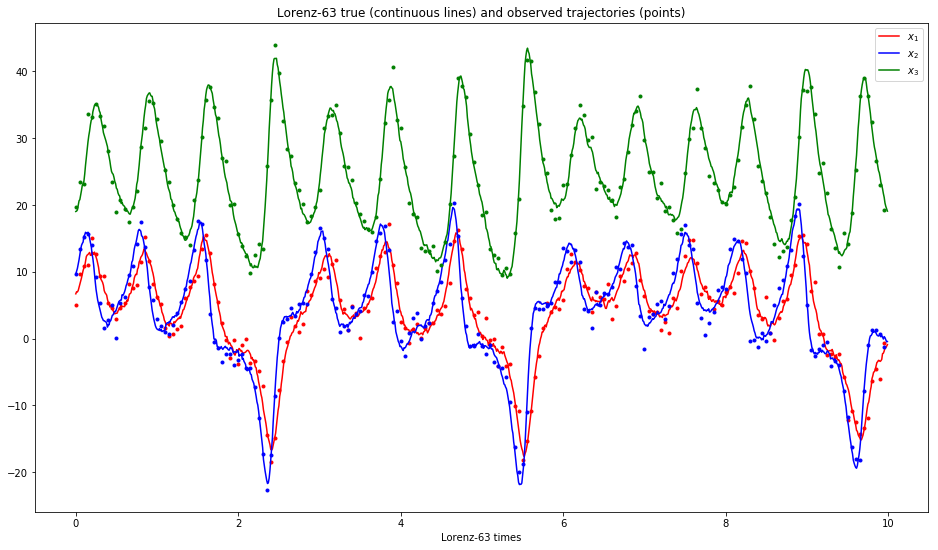

In [3]:
### PLOT STATE AND OBSERVATIONS

line1,=plt.plot(time,X_true[0,1:T+1],'-r');plt.plot(time,Yo[0,:],'.r')
line2,=plt.plot(time,X_true[1,1:T+1],'-b');plt.plot(time,Yo[1,:],'.b')
line3,=plt.plot(time,X_true[2,1:T+1],'-g');plt.plot(time,Yo[2,:],'.g')
plt.title('Lorenz-63 true (continuous lines) and observed trajectories (points)')
plt.xlabel('Lorenz-63 times')
plt.legend([line1, line2, line3], ['$x_1$', '$x_2$', '$x_3$'])

In [4]:
### INITIALIZE THE EM ALGORITHMS

# EM parameters
N_iter = 100
Q_init = np.eye(Nx)
R_init = np.eye(No)
N = 10 # number of members

# background state
xb, B = climat_background(X_true)

In [5]:
### APPLY THE EM ALGORITHM ON ENSEMBLE KALMAN SMOOTHER (EM-EnKS)

# parameters
params = { 'initial_background_state'                 : xb,
           'initial_background_covariance'            : B,
           'initial_model_noise_covariance'           : Q_init,
           'initial_observation_noise_covariance'     : R_init,
           'model_dynamics'                           : f,
           'observation_matrix'                       : H,
           'observations'                             : Yo,
           'nb_particles'                             : N,
           'nb_EM_iterations'                         : N_iter,
           'true_state'                               : X_true,
           'inflation_factor'                         : 1,
           'temporal_window_size'                     : T,
           'state_size'                               : Nx,
           'observation_size'                         : No,
           'is_model_noise_covariance_estimated'      : True,
           'is_observation_noise_covariance_estimated': True,
           'is_background_estimated'                  : True,
           'model_noise_covariance_structure'         : 'full'}

# function
res_EM_EnKS = EM_EnKS(params, prng)

100%|██████████| 100/100 [00:22<00:00,  4.41it/s]


In [6]:
### APPLY THE EM ALGORITHM ON ENSEMBLE TRANSFORM KALMAN SMOOTHER (EM-ETKS)

# parameters
params = { 'initial_background_state'                 : xb,
           'initial_background_covariance'            : B,
           'initial_model_noise_covariance'           : Q_init,
           'initial_observation_noise_covariance'     : R_init,
           'model_dynamics'                           : f,
           'observation_matrix'                       : H,
           'observations'                             : Yo,
           'nb_particles'                             : N,
           'nb_EM_iterations'                         : N_iter,
           'true_state'                               : X_true,
           'inflation_factor'                         : 1,
           'temporal_window_size'                     : T,
           'state_size'                               : Nx,
           'observation_size'                         : No,
           'is_model_noise_covariance_estimated'      : True,
        
          'is_observation_noise_covariance_estimated': True,
           'is_background_estimated'                  : True,
           'model_noise_covariance_structure'         : 'full'}

# function
res_EM_ETKS = EM_ETKS(params, prng)

  0%|          | 0/100 [00:00<?, ?it/s]/home/ptandeo/Dropbox/Documents/Codes/Python/CEDA/algos/EM_ETKS.py:116: ComplexWarning: Casting complex values to real discards the imaginary part
  Xa[:,:,t+1] = np.tile(np.mean(Xf[:,:,t],1), (Ne, 1)).T + Xf_bar[:,:,t].dot(W)
100%|██████████| 100/100 [00:33<00:00,  2.97it/s]


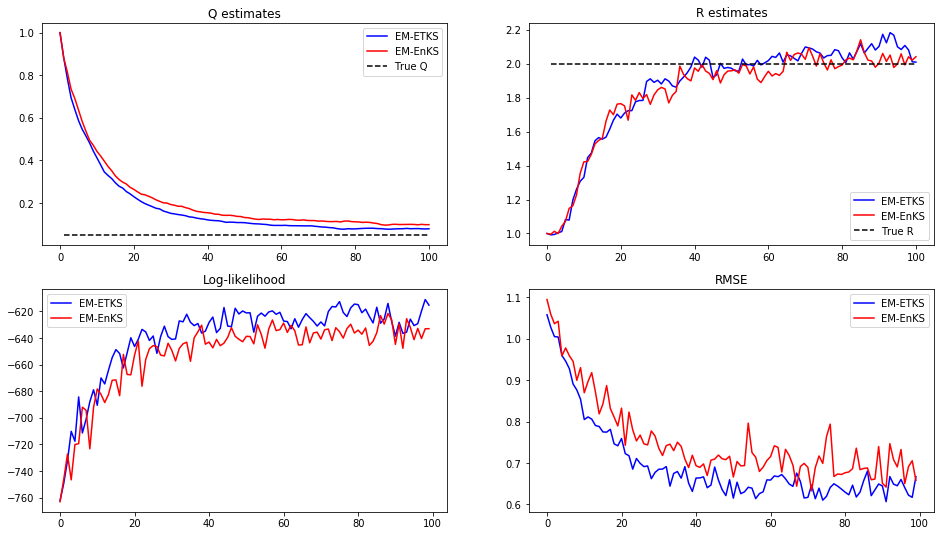

In [7]:
### COMPARE RESULTS BETWEEN THE TWO STRATEGIES (EM-EnKS AND EM-ETKS)

# extract outputs
Q_EnKS = res_EM_EnKS['EM_model_noise_covariance']
Q_ETKS = res_EM_ETKS['EM_model_noise_covariance']
R_EnKS = res_EM_EnKS['EM_observation_noise_covariance']
R_ETKS = res_EM_ETKS['EM_observation_noise_covariance']
loglik_EnKS=res_EM_EnKS['loglikelihood']
loglik_ETKS=res_EM_ETKS['loglikelihood']
RMSE_EnKS=res_EM_EnKS['RMSE']
RMSE_ETKS=res_EM_ETKS['RMSE']

# plot trace of Q
plt.subplot(2,2,1)
line1,=plt.plot(np.trace(Q_ETKS)/Nx,'b')
line2,=plt.plot(np.trace(Q_EnKS)/Nx,'r')
line3,=plt.plot((1,N_iter),(np.trace(Q_true)/Nx,np.trace(Q_true)/Nx),'--k')
plt.title('Q estimates')
plt.legend([line1, line2, line3], ['EM-ETKS', 'EM-EnKS', 'True Q'])

# plot trace of R
plt.subplot(2,2,2)
line1,=plt.plot(np.trace(R_ETKS)/No,'b')
line2,=plt.plot(np.trace(R_EnKS)/No,'r')
line3,=plt.plot((1,N_iter),(np.trace(R_true)/No,np.trace(R_true)/No),'--k')
plt.title('R estimates')
plt.legend([line1, line2, line3], ['EM-ETKS', 'EM-EnKS', 'True R'])

# plot log-likelihood
plt.subplot(2,2,3)
line1,=plt.plot(loglik_ETKS,'b')
line2,=plt.plot(loglik_EnKS,'r')
plt.title('Log-likelihood')
plt.legend([line1, line2], ['EM-ETKS', 'EM-EnKS'])

# plot Root Mean Square Error
plt.subplot(2,2,4)
line1,=plt.plot(RMSE_ETKS,'b')
line2,=plt.plot(RMSE_EnKS,'r')
plt.title('RMSE')
plt.legend([line1, line2], ['EM-ETKS', 'EM-EnKS'])

In [32]:
### GENERATE SIMULATED DATA (LORENZ 96 MODEL)

# random number generator
prng = RandomState(1)

# dynamical model
Nx = 40 # dimension of the state
dt = .05 # integration time
F = 8 # physical parameter
# f = lambda x: l96_predict(x,dt,F) # python version (slow)
fmdl=mdl_l96.M(dtcy=dt, force=F, nx=Nx)
f = lambda x: fmdl.integ(x) # fortran version (fast)

# observation operator
No = 40 # dimension of the observations
h = lambda x: x
jacH = lambda x: np.eye(Nx)
H = np.eye(Nx)

# size of the sequence
T = 400 # 20 Lorenz-96 times
time = range(T+1)*array([dt])

# generate state
spatial_cov_Q = lambda dist: 0.1*exp(-dist/5)
Q_true=spatial_cov_Q(0)*eye(Nx)
for i_dist in range(1,20):
    Q_true += diag(spatial_cov_Q(i_dist)*ones(Nx-i_dist),i_dist) + diag(spatial_cov_Q(i_dist)*ones(Nx-i_dist),-i_dist)
    Q_true += diag(spatial_cov_Q(i_dist)*ones(i_dist),Nx-i_dist) + diag(spatial_cov_Q(i_dist)*ones(i_dist),Nx-i_dist).T
i_dist = 20
Q_true += diag(spatial_cov_Q(i_dist)*ones(Nx-i_dist),i_dist) + diag(spatial_cov_Q(i_dist)*ones(Nx-i_dist),-i_dist)
#Q_true = np.eye(Nx) * .1
X0_true = array(zeros(Nx))
X_true = gen_truth(f, X0_true, T+50, Q_true, prng)

# generate observations
dt_obs = 2 # 1 observation every dt_obs time steps
R_true = np.eye(No) * 2
Yo = gen_obs(h, X_true, R_true, dt_obs, prng)

# remove first part of the sequence (time to converge to the attractor)
X_true = X_true[:,50:T+50+1]
Yo = Yo[:,50:T+50+1]

Text(0.5,1,'Observed trajectories')

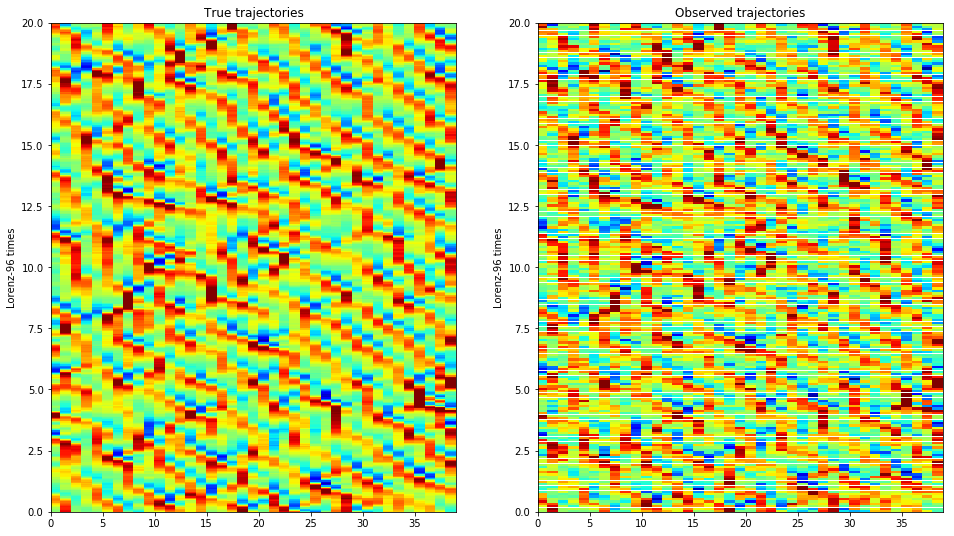

In [33]:
### PLOT STATE AND OBSERVATIONS

[X,Y]=meshgrid(range(Nx),time)
subplot(1,2,1);pcolor(X,Y,X_true.T,cmap='jet');xlim([0,Nx-1]);clim([-10,10]);ylabel('Lorenz-96 times');title('True trajectories')
subplot(1,2,2);pcolor(X,Y,ma.masked_where(isnan(Yo.T),Yo.T),cmap='jet');xlim([0,Nx-1]);clim([-10,10]);ylabel('Lorenz-96 times');title('Observed trajectories')

In [45]:
### INITIALIZE THE EM ALGORITHMS

# EM parameters
N_iter = 100
Q_init = np.eye(Nx)
R_init = np.eye(No)
N = 50 # number of members

# background state
xb, B = climat_background(X_true)

In [46]:
### APPLY THE EM ALGORITHM ON ENSEMBLE KALMAN SMOOTHER (EM-EnKS)

# parameters
params = { 'initial_background_state'                 : xb,
           'initial_background_covariance'            : B,
           'initial_model_noise_covariance'           : Q_init,
           'initial_observation_noise_covariance'     : R_init,
           'model_dynamics'                           : f,
           'observation_matrix'                       : H,
           'observations'                             : Yo,
           'nb_particles'                             : N,
           'nb_EM_iterations'                         : N_iter,
           'true_state'                               : X_true,
           'inflation_factor'                         : 1,
           'temporal_window_size'                     : T,
           'state_size'                               : Nx,
           'observation_size'                         : No,
           'is_model_noise_covariance_estimated'      : True,
           'is_observation_noise_covariance_estimated': True,
           'is_background_estimated'                  : True,
           'model_noise_covariance_structure'         : 'full',
           #'model_noise_covariance_matrix_template'   : np.eye(Nx) # only for constant model noise covariance
         }

# function
res_EM_EnKS = EM_EnKS(params, prng)

100%|██████████| 100/100 [02:05<00:00,  1.26s/it]


In [47]:
### APPLY THE EM ALGORITHM ON ENSEMBLE TRANSFORM KALMAN SMOOTHER (EM-ETKS)

# parameters
params = { 'initial_background_state'                 : xb,
           'initial_background_covariance'            : B,
           'initial_model_noise_covariance'           : Q_init,
           'initial_observation_noise_covariance'     : R_init,
           'model_dynamics'                           : f,
           'observation_matrix'                       : H,
           'observations'                             : Yo,
           'nb_particles'                             : N,
           'nb_EM_iterations'                         : N_iter,
           'true_state'                               : X_true,
           'inflation_factor'                         : 1,
           'temporal_window_size'                     : T,
           'state_size'                               : Nx,
           'observation_size'                         : No,
           'is_model_noise_covariance_estimated'      : True,
           'is_observation_noise_covariance_estimated': True,
           'is_background_estimated'                  : True,
           'model_noise_covariance_structure'         : 'full',
           #'model_noise_covariance_matrix_template'   : np.eye(Nx) # only for constant model noise covariance
         }

# function
res_EM_ETKS = EM_ETKS(params, prng)

  0%|          | 0/100 [00:00<?, ?it/s]/home/ptandeo/Dropbox/Documents/Codes/Python/CEDA/algos/EM_ETKS.py:116: ComplexWarning: Casting complex values to real discards the imaginary part
  Xa[:,:,t+1] = np.tile(np.mean(Xf[:,:,t],1), (Ne, 1)).T + Xf_bar[:,:,t].dot(W)
100%|██████████| 100/100 [03:15<00:00,  1.96s/it]


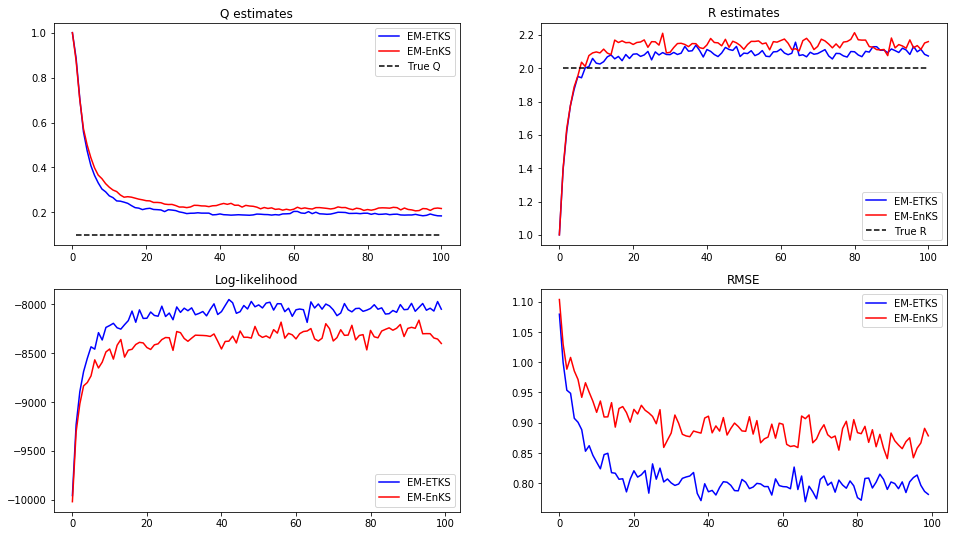

In [48]:
### COMPARE RESULTS BETWEEN THE TWO STRATEGIES (EM-EnKS AND EM-ETKS)

# extract outputs
Q_EnKS = res_EM_EnKS['EM_model_noise_covariance']
Q_ETKS = res_EM_ETKS['EM_model_noise_covariance']
R_EnKS = res_EM_EnKS['EM_observation_noise_covariance']
R_ETKS = res_EM_ETKS['EM_observation_noise_covariance']
loglik_EnKS=res_EM_EnKS['loglikelihood']
loglik_ETKS=res_EM_ETKS['loglikelihood']
RMSE_EnKS=res_EM_EnKS['RMSE']
RMSE_ETKS=res_EM_ETKS['RMSE']

# plot trace of Q
plt.subplot(2,2,1)
line1,=plt.plot(np.trace(Q_ETKS)/Nx,'b')
line2,=plt.plot(np.trace(Q_EnKS)/Nx,'r')
line3,=plt.plot((1,N_iter),(np.trace(Q_true)/Nx,np.trace(Q_true)/Nx),'--k')
plt.title('Q estimates')
plt.legend([line1, line2, line3], ['EM-ETKS', 'EM-EnKS', 'True Q'])

# plot trace of R
plt.subplot(2,2,2)
line1,=plt.plot(np.trace(R_ETKS)/No,'b')
line2,=plt.plot(np.trace(R_EnKS)/No,'r')
line3,=plt.plot((1,N_iter),(np.trace(R_true)/No,np.trace(R_true)/No),'--k')
plt.title('R estimates')
plt.legend([line1, line2, line3], ['EM-ETKS', 'EM-EnKS', 'True R'])

# plot log-likelihood
plt.subplot(2,2,3)
line1,=plt.plot(loglik_ETKS,'b')
line2,=plt.plot(loglik_EnKS,'r')
plt.title('Log-likelihood')
plt.legend([line1, line2], ['EM-ETKS', 'EM-EnKS'])

# plot Root Mean Square Error
plt.subplot(2,2,4)
line1,=plt.plot(RMSE_ETKS,'b')
line2,=plt.plot(RMSE_EnKS,'r')
plt.title('RMSE')
plt.legend([line1, line2], ['EM-ETKS', 'EM-EnKS'])

Text(0.5,1,'R (EM-ETKS)')

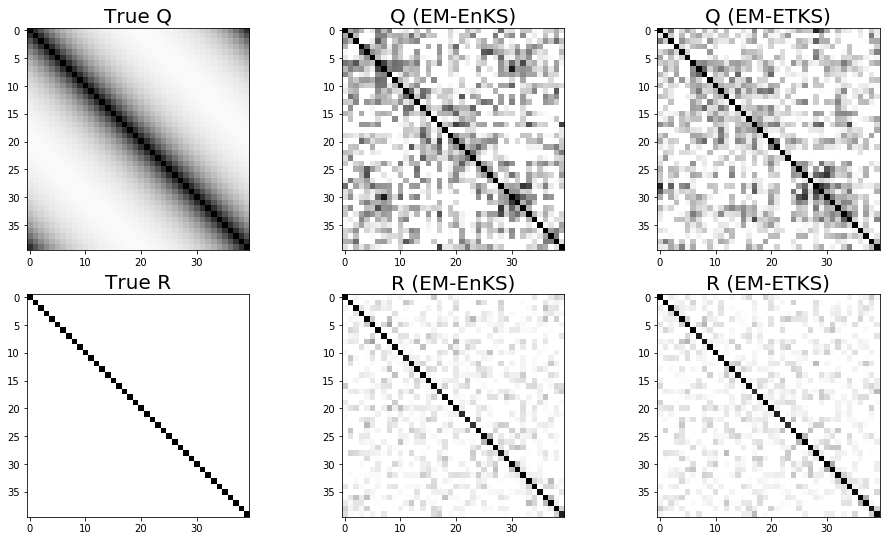

In [49]:
chosen_cmap = plt.get_cmap('gray_r')

# true Q
plt.subplot(2,3,1)
plt.imshow(Q_true, cmap=chosen_cmap)
plt.clim([0,0.1])
plt.title('True Q', fontsize=20)

# Q (EM-EnKS)
plt.subplot(2,3,2)
plt.imshow(Q_EnKS[:,:,-1], cmap=chosen_cmap)
plt.clim([0,0.1])
plt.title('Q (EM-EnKS)', fontsize=20)

# Q (EM-ETKS)
plt.subplot(2,3,3)
plt.imshow(Q_ETKS[:,:,-1], cmap=chosen_cmap)
plt.clim([0,0.1])
plt.title('Q (EM-ETKS)', fontsize=20)

# true R
plt.subplot(2,3,4)
plt.imshow(R_true, cmap=chosen_cmap)
plt.clim([0,2])
plt.title('True R', fontsize=20)

# R (EM-EnKS)
plt.subplot(2,3,5)
plt.imshow(R_EnKS[:,:,-1], cmap=chosen_cmap)
plt.clim([0,2])
plt.title('R (EM-EnKS)', fontsize=20)

# R (EM-ETKS)
plt.subplot(2,3,6)
plt.imshow(R_ETKS[:,:,-1], cmap=chosen_cmap)
plt.clim([0,2])
plt.title('R (EM-ETKS)', fontsize=20)